In [1]:
#THIS PIPELINE ASSUMING YOU JUST FINISHED RUNNING d415_acquisition_color_and_rgb_and_compress.ipynb
#IF YOU ARE JUST STARTING WITH RAW BINARY FILES THEN SKIP BELOW TO WHERE IT SAYS "START HERE IF JUST WORKING WITH...
#DON'T FORGET THE IMPORTS THOUGH

In [2]:
#DEFAULT PARAMS IN CASE YOU DON'T HAVE THE VARIABLES FILE
#IF THAT'S THE CASE YOU ALSO NEED TO SPECIFY NUMBER OF FRAMES AND BACKGROUND CHUNK LENGTH
frame_height=480
frame_width=640
fps=30
box_size=192
stringency=30
min_range=0
max_range=1000
grand_frame=0
background_chunk=600
number_of_frames=60000

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random
import gzip
import matplotlib.colors as mcol
import matplotlib.cm as cm
import pickle
import os
import imageio
import gc
import cv2
from scipy import stats
from scipy import ndimage #for finding com
from scipy.misc import imsave
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [4]:
#Change to directory that contains the ouput of d415_acquisition_color_and_rgb_and_compress.ipynb
os.chdir("/home/rockwell/Real_Sensible_Moseq/data_acquisition/")

In [5]:
#enter folder name
experiment=input("Regarding experiment date and number (six digit id): Enter YYMMDD_######   -")

Regarding experiment date and number (six digit id): Enter YYMMDD_######   -180926_test_2_background_subtract_200_frames


In [6]:
os.chdir(experiment)
os.mkdir(experiment+'_depth_frames')
os.mkdir(experiment+'_color_frames')

In [7]:
with open(experiment+'_variables', 'rb') as variables:
    number_of_frames,frame_height,frame_width,fps,background_chunk = pickle.load(variables)
    
exp_numb=0
box_size=192
stringency=30 #10 for d415 50 for sr300
grand_frame=int(exp_numb*(number_of_frames-background_chunk))
min_range=0
max_range=300 #1000

In [8]:
decompress=input("do you need to decompress? (type yes or no)")
if decompress=="yes":

    depthfilename='%s_raw_depth.gz'%experiment
    colorfilename='%s_raw_color.gz'%experiment

    #Load and uncompress data (depth)
    input_file = gzip.GzipFile(colorfilename, 'rb')
    data = input_file.read()
    input_file.close()

    output_file = open("pythoncolordata.bin", 'wb')
    output_file.write(data)
    output_file.close()

    #Load and uncompress data (color)
    input_file = gzip.GzipFile(depthfilename, 'rb')
    data = input_file.read()
    input_file.close()

    output_file = open("pythondepthdata.bin", 'wb')
    output_file.write(data)
    output_file.close()

do you need to decompress? (type yes or no)no


In [26]:
#START FROM HERE IF JUST WORKING WITH RAW BINARY FILES, YOU MAY NEED TO RENAME YOU DEPTH AND COLOR BINARY FILES TO depthdata.bin and colordata.bin

depthframes = np.fromfile('pythondepthdata.bin', dtype=np.uint16).reshape(-1, frame_height, frame_width)
depth_background_frames = depthframes[0:background_chunk]
depthframes=depthframes[background_chunk:number_of_frames]
depthbackgroundmean=np.median(depth_background_frames, axis=0) #may be better to use median
depthbackgroundvariance=np.var(depth_background_frames, axis=0)


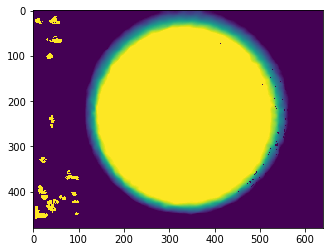

In [27]:
plt.imshow(depth_background_frames[6])
plt.clim(600,700)

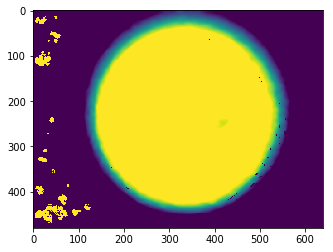

In [28]:
plt.imshow(depthframes[60])
plt.clim(600,700)

In [12]:
colorframes = np.fromfile('pythoncolordata.bin', dtype=np.uint8).reshape(-1, frame_height, frame_width,3)
color_background_frames=colorframes[0:background_chunk]
colorframes=colorframes[background_chunk:number_of_frames]

colorbackgroundmean=np.median(color_background_frames, axis=0) #may be better to use median
colorbackgroundvariance=np.var(color_background_frames, axis=0)

colorbackgroundmean=np.dot(colorbackgroundmean[...,:3], [.33, .34, .33])
colorbackgroundvariance=np.dot(colorbackgroundvariance[...,:3], [.33, .34, .33])

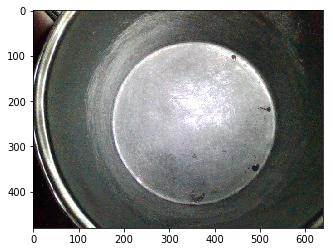

In [24]:
plt.imshow(color_background_frames[58])

In [78]:
min_range=0
stringency=8
current_frame=0
colorframes = np.fromfile('pythoncolordata.bin', dtype=np.uint8).reshape(-1, frame_height, frame_width,3)[background_chunk:number_of_frames]

for f in range(int(number_of_frames-background_chunk)):
        
    #FRAME TO PROCESS#################################################################
    #depth
    depth_frame_of_interest=depthframes[current_frame] 
    color_frame_of_interest=colorframes[current_frame] 
    #color
    color_frame_of_interest=np.dot(color_frame_of_interest[...,:3], [.33, .34, .33])
    
    #DEPTH BACKGROUND SUBTRACTION#####################################################
    #Background subtraction with no filters
    
    #IF PIXEL ISN'T SIGNIFICANTLY DIFFERENT FROM THE BACKGROUND THEN DROP IT
    backgroundmultiplier=np.abs(depth_frame_of_interest - depthbackgroundmean) - (stringency*np.sqrt(depthbackgroundvariance)) 
    

    #WE EXPECT POSITIVE VALUES FOR HIGH DIFFERENCES make them stay by multiplying by 1
    backgroundmultiplier[backgroundmultiplier>0]=1
    #WE EXPECT NEGATIVE VALUES FOR SMALL OR NO DIFFERENCE probably just noise, get rid of them by multiplying by 0
    backgroundmultiplier[backgroundmultiplier<=0]=0
       
    # SUBTRACT BACKGROUND BY MULTIPLYING INSIGNIFIACNT FRAMES BY ZERO
    depth_frame_of_interest_backgroundsubtracted=(np.multiply(depth_frame_of_interest,backgroundmultiplier)).astype('uint8') #IMWRITE TAKES UINT8
    depth_frame_of_interest_backgroundsubtracted[depth_frame_of_interest_backgroundsubtracted>max_range]=0
    depth_frame_of_interest_backgroundsubtracted[depth_frame_of_interest_backgroundsubtracted<=min_range]=0
        
    #FIND CENTER OF MOUSE FOR CROPPING ##########################################################################
    #ALGORITHIM FOR FINDING THE CENTER OF THE OBJECT (TO CROP THE PLOT) (this actually works better than any built in function I've tried)
    #basically, the row and column with the most non zero values should be the center
    
    #remove the triple quotes around this algorithim in order to save data as cropped pngs below
    
    winningrow=0
    winningcountr=frame_width
    for rowpixels in range(0,frame_height):
        currentcountr=np.count_nonzero(depth_frame_of_interest_backgroundsubtracted[rowpixels,:]==0)
        if currentcountr<winningcountr:
            winningcountr=currentcountr
            winningrow=rowpixels

    winningcolumn=0
    winningcountc=frame_height
    for columnpixels in range(0,frame_width):
        currentcountc=np.count_nonzero(depth_frame_of_interest_backgroundsubtracted[:,columnpixels]==0)
        if currentcountc<winningcountc:
            winningcountc=currentcountc
            winningcolumn=columnpixels

    if winningrow<(box_size/2):
        winningrow=(int(box_size/2))
    if winningrow>(frame_height-box_size/2):
        winningrow=int(frame_height-box_size/2-1)
    if winningcolumn<(box_size/2):
        winningcolumn=(int(box_size/2))
    if winningcolumn>(frame_width-box_size/2):
        winningcolumn=int(frame_width-box_size/2-1)
   
        
    #LABEL FRAMES ####################################################################

        #THIS IS THE FRAME NUMBER (I WILL COMBINE MANY RUNS SO I'M OUTPUTTING THE MASTER FRAME NUMBER)
    fplusd=int(f+grand_frame)
    print(fplusd)
       
    #SAVE DATA AS PNGS##################################################################
    
        # CROPPED: THIS IS HOW I SHOULD SAVE ARRAYS SO THEY COME OUT AS 192 by 192 FOR IMAGE ANALYSIS (IT'S SMALLER!)
    #imageio.imwrite(experiment + '_depth_frames/depth_frame_%06d.png' %(fplusd),depth_frame_of_interest_backgroundsubtracted[winningrow-int(box_size/2):winningrow+int(box_size/2),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2)])
    imageio.imwrite(experiment + '_color_frames/color_frame_%06d.png' %(fplusd),color_frame_of_interest[winningrow-int(box_size/2):winningrow+int(box_size/2),winningcolumn-int(box_size/2):winningcolumn+int(box_size/2)])
    
        # SAVE DATA AS PNGS (FULL SIZE)
    imageio.imwrite(experiment + '_depth_frames/color_frame_%06d.png' %(fplusd),depth_frame_of_interest)
    #imageio.imwrite(experiment + '_color_frames/color_frame_%06d.png' %(fplusd),color_frame_of_interest)

    current_frame=current_frame+1
        

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


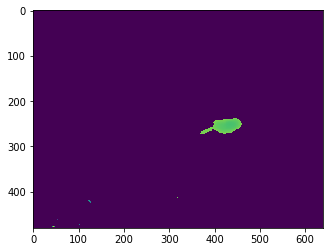

In [29]:
plt.imshow(depth_frame_of_interest_backgroundsubtracted)

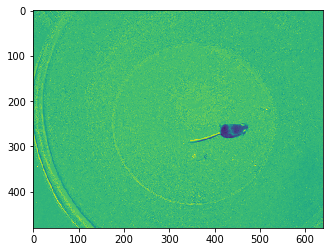

In [79]:
plt.imshow(np.subtract(color_frame_of_interest,(colorbackgroundmean)))

In [121]:
y=np.add (np.divide(color_frame_of_interest,(colorbackgroundmean))>3 ,  np.divide(color_frame_of_interest,(colorbackgroundmean))<.9 )

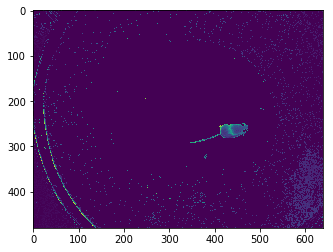

In [122]:
plt.imshow(np.multiply(color_frame_of_interest,y))
x=np.multiply(color_frame_of_interest,y)
from scipy.ndimage.filters import gaussian_filter , median_filter
blurred =gaussian_filter(x,sigma=1)

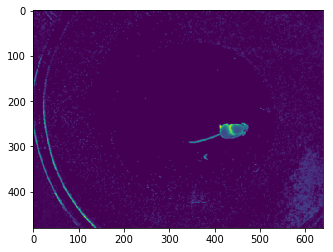

In [123]:
plt.imshow(blurred)

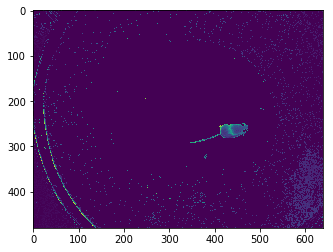

In [124]:
blurred2=median_filter(x,1)
plt.imshow(blurred2)

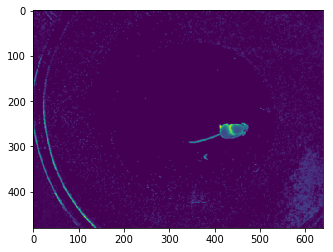

In [126]:
blurred3=gaussian_filter(blurred2,sigma=1)
plt.imshow(blurred3)

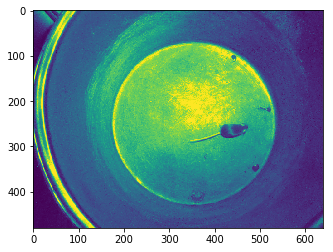

In [76]:
plt.imshow(color_frame_of_interest)

In [33]:
x=np.subtract(color_frame_of_interest,(colorbackgroundmean/255))
x[x<.1]=0

In [18]:
np.sqrt(colorbackgroundvariance)

array([[20.94064765, 21.91263845, 21.83432793, ..., 13.37058293,
        13.92090615, 13.96572508],
       [20.36401675, 21.41409718, 21.80434248, ..., 12.74266844,
        13.08171541, 12.87799616],
       [19.06873058, 20.89860572, 20.57445635, ..., 11.49642079,
        11.95815195, 12.17818751],
       ...,
       [ 3.11656863,  4.23572379,  3.43277351, ..., 10.85821302,
         9.78468272,  9.53769673],
       [ 3.22725952,  5.17628419,  3.37138369, ..., 10.22186622,
         8.71253356,  8.31708068],
       [ 3.2750629 ,  6.63645576,  5.84530427, ...,  8.89145022,
         8.10804989,  8.02016777]])

In [19]:
color_frame_of_interest*255

array([[17929.05, 20479.05, 20165.4 , ...,  7889.7 ,  5900.7 ,  5135.7 ],
       [17334.9 , 20139.9 , 19992.  , ...,  9771.6 ,  4620.6 ,  4620.6 ],
       [17416.5 , 20731.5 , 19731.9 , ...,  5446.8 ,  3850.5 ,  3850.5 ],
       ...,
       [ 1948.2 ,  1948.2 ,  2198.1 , ...,  8420.1 ,  6890.1 ,  7655.1 ],
       [ 1438.2 ,  1693.2 ,  2198.1 , ...,  8086.05,  4936.8 ,  6466.8 ],
       [ 1183.2 ,  1438.2 ,  1514.7 , ...,  5541.15,  4508.4 ,  3743.4 ]])

In [20]:
np.divide(abs(np.subtract(color_frame_of_interest*255,np.sqrt(colorbackgroundvariance))),

SyntaxError: unexpected EOF while parsing (<ipython-input-20-5868be9a8856>, line 1)

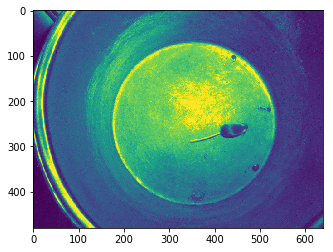

In [34]:
plt.imshow(x)

In [ ]:
plt.imshow(depth_frame_of_interest_backgroundsubtracted)

In [ ]:
#you can choose to remove the thing you just unzipped
#!rm colordata.bin
#!rm depthdata.bin

In [ ]:
plt.hist(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0],bins=range(-1000,1000))
plt.show()

In [ ]:
#when finished processing on the cluster I can transfer files back to my desktop with...
# !scp -r ra206@transfer.rc.hms.harvard.edu:/n/groups/datta/rockwell/Real_Sensible_Moseq/data_acquisition/180731_000002/180731_000002_depth_frames/  ~/Real_Sensible_Moseq/data

#I can make mp4s with
#!ffmpeg -r 30 -i /home/rockwell/Real_Sensible_Moseq/data_acquisition/nowalls/nowalls_depth_frame_%06d.png -c:v libx264 -vf fps=90 -pix_fmt yuv420p -r 30 nowalls_depth.mp4
